## Interpolation Module

## Introduction
To simulate Daedalus measurments using physics based model such as TIEGCM 
values of gridded data have to be interpolateds to the spacecraft's positions.In
Daedalus Maze this is provided by the Interpolation Module which is described below.

The Interpolation Module consists of a family of  codes written in python FORTRAN and C++.

## Basic Input and Output
The Interpolation Module supports Dedalus Input orbits in netcdf format and exports the interpolation
results in netcdf as well.

## Performance and Parallelization Level
The python version of the Inteprolation Modules supports single threaded and multi threaded workloads using the multiprocessing library. At the same, the user can opt to call the pre-compiled low-level FORTRAN subroutines which can handle both the single threaded and the multi threaded interpolations using OpenMP.

The C++ version, uses the OpenMPI and OpenMP interface and can support massive scalability on distributed memory using hybrid programming,splitting the interpolations in threads and nodes.The same basic input and output interface is used as with the python version.

Finally there is a version of the Interpolation Module written in C++ using a CUDA kernel to speed up the interpolation process. On a shared memory environment this is by far the fastest version, outperforming the 
python version by more than three orders of magnitude.






## Skeleton of the Interpolation Module


## The Model Class: 
This class handles basic IO of the Model Data extracting grid quintities and variables as selected by
the user to be used in the interpolation.


In [1]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
%matplotlib inline  
import pandas as pd
import numpy as np
import pandas as pd
from pandas import DataFrame
from datetime import datetime
import time
import os
import sys
import multiprocessing
from functools import partial
from scipy.signal import savgol_filter
import warnings
warnings.filterwarnings('ignore')

In [2]:
class Model:
    def __init__(self,name, maxAltitude, minAltitude):
        self.name=name
        self.maxAltitude=maxAltitude
        self.minAltitude=minAltitude


    def readGrid(self,name):
        TIEGCM=Dataset(name+".nc")
        glat=TIEGCM.variables['lat'][:]
        glon=TIEGCM.variables['lon'][:]
        glev=TIEGCM.variables['lev'][:]
        gtime=TIEGCM.variables['time'][:]
        zg=TIEGCM.variables['ZG'][:]
        TIEGCM.close()

        return np.asarray(gtime),np.asarray(glat),np.asarray(glon),np.asarray(glev),np.asarray(zg)

    def readVar(self,model,name):
        TIEGCM=Dataset(model+".nc")
        var=TIEGCM.variables[name][:]
        TIEGCM.close()
        return var

## The Orbit Class: 
This class  This class handles basic IO of Daedalus' orbit allocating arrays for the spatial components. The longitudinal component is matched to TIEGCM's  and points in a specific altitudinal range are extracted to be passed to the interpolation routine. There is also an option for creating a Rocket orbit for getting 
vertical profiles of the said model.

In [3]:

class Orbit:
    def __init__(self,name):
        self.name=name


    def createorbit(self,filename,minAlt,maxAlt):
        orbit=Dataset(filename+".nc","r")
        daed_lat_temp = orbit.variables['lat'][:]
        daed_lon_temp = orbit.variables['lon'][:]
        daed_alt_temp = orbit.variables['altitude'][:]
        daed_time_temp = orbit.variables['time'][:]

  
        counter=0
        for i in range(0,len(daed_alt_temp)):
            if (daed_alt_temp[i] < maxAlt and daed_alt_temp[i] > minAlt):
                counter=counter+1
       
        daed_lat=np.zeros((counter))
        daed_lon=np.zeros((counter))
        daed_alt=np.zeros((counter))
        daed_time=np.zeros((counter),dtype=datetime)

   
        counter2=0
        
        for i in range(0,len(daed_alt_temp)):
    
            if (daed_alt_temp[i] < maxAlt and daed_alt_temp[i] > minAlt):
         
                daed_time[counter2]=daed_time_temp[i]
                daed_lat[counter2]=daed_lat_temp[i]
                daed_lon[counter2]=daed_lon_temp[i]-180.0 #match TIEGCM grid
                daed_alt[counter2]=daed_alt_temp[i]
                
                # index[counter2]=i          #keep indices for merging data
                counter2=counter2+1

        return(daed_time,daed_lat,daed_lon,daed_alt)

    def RockeOrbit(self,lat,lon,alt,nop,dz):
        Rlat=np.zeros(nop)
        Rlon=np.zeros(nop)
        Ralt=np.zeros(nop)

        Rlat[:]=lat
        Rlon[:]=lon
        Ralt[0]=alt
        for i in range(1,nop):
            Ralt[i]=Ralt[i-1]+dz

        return Rlat,Rlon,Ralt


Functions used by the Interpolation Module
The geod2geo_lat converts geodetic latitude to geographic latitude

In [4]:
def geod_lat2geo_lat(phi):

    # calculate geocentric latitude from geodetic latitude
    # according to WGS 84
    a = 6378137  # meter semi major axis of earth
    f = 1 / 298.257  # flattening
    b = a - f * a  # semi minor axis
    e = ((a ** 2 - b ** 2) ** (1 / 2)) / a
    phi_rad = np.deg2rad(phi)
    geo_lat = np.arctan((1 - e ** 2) * np.tan(phi_rad))
    geo_lat = np.rad2deg(geo_lat)
    return geo_lat  # in degrees

The function local is used to find the local neighbors of a specific component in a non eqwually spaced array 
such as the pressure levels in the TIEGCM

In [5]:

def local(dim1,y,x):
    local_pos=0
    for i in range(0,len(x)-1):
        if y >= x[i] and y < x[i+1]:
            local_pos=i
            return (local_pos)
    return (local_pos)

The single threaded inteprolation core routine which iterates over Daedalus orbit and performs the interpolation.
At every spatial position weights are assigned to the  8 local grid neighbours and then the interpolated value is calculated using trilinear interpolation.

In [6]:

def Interpolate_Serial(glat,glon,glev,dlat,dlon,dalt,zg,ne,Plot=False):
    counter=11
    deltaphi= np.abs(glon[2]-glon[1])
    deltatheta=np.abs(glat[2]-glat[1])
    Re=6378137.0/1e3
    # arc_theta=2*np.pi*Re*(deltatheta/360)
    # arc_phi=2*np.pi*Re*(deltaphi/360)

    m=np.zeros((len(dalt)))
    tn=np.zeros((len(dalt)))
    pn=np.zeros((len(dalt)))

    for i in range(0,len(dalt)):


        
        phi_local=local(len(glon),dlon[i],glon)
        theta_local=local(len(glat),dlat[i],glat)


        if dlon[i] >= 177.5 :
            phi_local=len(glon)-2
            lonbnd=1

        if dlon[i] <= -177.5:
            phi_local=1

        if dlat[i] >= 87.5:
            theta_local=len(glat)-2
            latbnd=1

        if dlat[i] <= -87.5:
            theta_local=0


        alts=zg[counter,:,theta_local,phi_local]/1e5
        r_local=local(len(alts),dalt[i],alts)
        deltarho=alts[r_local+1]-alts[r_local]
        dx=(((dalt[i]-alts[r_local])/deltarho))
        dy=(((dlat[i]-glat[theta_local])/deltatheta))
        dz=np.abs(((dlon[i]-glon[phi_local])/deltaphi))

        # Calculate Neighbors
        pn[i]=ne[counter,r_local,theta_local,phi_local]

        
        w1=np.abs((1-dx)*(1-dy)*(1-dz))
        w2=np.abs((dx)*(1-dy)*(1-dz))
        w3=np.abs((1-dx)*(dy)*(1-dz))
        w4=np.abs((dx)*(dy)*(1-dz))
        w5=np.abs((1-dx)*(1-dy)*(dz))
        w6=np.abs((dx)*(1-dy)*(dz))
        w7=np.abs((1-dx)*(dy)*(dz))
        w8=np.abs((dx)*(dy)*(dz))

        
        m[i]=0.0
        m[i]=       ne[counter,r_local,theta_local,phi_local]*w1
        m[i]=m[i]+  ne[counter,r_local+1,theta_local,phi_local]*w2
        m[i]=m[i]+  ne[counter,r_local,theta_local+1,phi_local]*w3
        m[i]=m[i]+  ne[counter,r_local+1,theta_local+1,phi_local]*w4

        m[i]=m[i]+  ne[counter,r_local,theta_local,phi_local+1]*w5
        m[i]=m[i]+  ne[counter,r_local+1,theta_local,phi_local+1]*w6
        m[i]=m[i]+  ne[counter,r_local,theta_local+1,phi_local+1]*w7
        m[i]=m[i]+  ne[counter,r_local+1,theta_local+1,phi_local+1]*w8


        if np.abs(w1+w2+w3+w4+w5+w6+w7+w8 -1.0) >1e-2:
            m[i]=m[i-1]
    m=savgol_filter(m, 51, 3)
    if Plot== True:
        plt.figure(1)
        plt.plot(m)
        plt.title("Interpolated Data [TN]")
        plt.xlabel("Measurements")
        plt.ylabel("Neutral Temperature [K]")
        


    return (m)


## A sample call to the Interpolation Module:

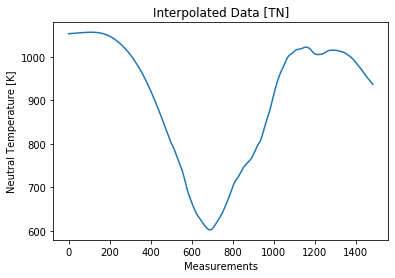

In [7]:
# model_data_file="tiegcm_dres.s_mar2015_amie_v1_31"
# orbit_file="DAED_ORB_Evt0_LLA_Per120_Lat80_Srt01Hz_Msc"

model_data_file="/home/NAS/TIEGCM_DATA/TIEGCM_EVT1_2015_StPatricksDay_HAO/tiegcm_dres.s_mar2015_amie_v1_31"
orbit_file="/home/NAS/Data_Files/OrbitData/DAED_ORB_Evt0_LLA_Per120_Lat80_Srt01Hz_Msc"
model=Model(model_data_file ,550,120)  #initialize model
orbit=Orbit(orbit_file)                #initialize orbit
dtime,dlat,dlon,dalt=orbit.createorbit(orbit.name,model.minAltitude,model.maxAltitude) #get orbit
gtime,glat,glon,glev,zg=model.readGrid(model.name)                                     #get model stats
var=model.readVar(model.name,"TN")                                                     #select variable
interpolatedData=Interpolate_Serial(glat,glon,glev,dlat,dlon,dalt,zg,var,True)         #inteprolate

